# **Kelompok 5**
- **1. Ananda Putra W.R. (22081010038)**
- **2. Muhammad Fajar S. (22081010065)**
- **3. Ade Rizky Panjaitan (22081010091)**

# Pneumonia X-ray Classifier, split `train` 70/15/15, Threshold Tuning, Fine-tune, Class-Weight
#
**Tujuan:** Klasifikasi **PNEUMONIA vs NORMAL**.
- Import **langsung dari Kaggle** via **KaggleHub**.
- **Hanya** pakai folder `train/` dari dataset Kaggle → **split 70/15/15** (train/val/test) secara **stratified**.
- **Balancing** TRAIN ke **2.000 per kelas** (oversample/undersample).
- Transfer learning **MobileNetV2** + augmentasi.
- **Simpan model .h5** (best & final) **sebelum prediksi**.
- **Tambahan**: Threshold tuning (target recall ≥ 0.95), class/cost-sensitive &/atau **Focal Loss**, **fine-tuning** backbone, **TTA**, **kalibrasi (Platt scaling)**, dan **prediksi gambar custom** `normal.png`.

## Alur Proses
1. Import library  
2. Download dataset via KaggleHub  
3. Ambil hanya `train/` → DataFrame  
4. Split 70/15/15 (stratified)  
5. **Hitung `class_weight`** dari distribusi TRAIN  
6. Data generator (augmentasi + `preprocess_input`)  
7. Bangun & latih model (MobileNetV2) dgn `class_weight`  
8. Simpan `.h5`  
9. Evaluasi baseline (threshold 0.5)  
10. **Kurva ROC/PR** & **diagram metrik vs threshold**  
11. **Pilih threshold**: pro-NORMAL & pro-PNEUMONIA (serta Youden & F1-opt)  
12. Prediksi gambar custom + tampilkan confidence

In [ ]:
# ============== 1) IMPORT LIBRARY ==============
import os, sys, glob, random, json, math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score)
from sklearn.utils.class_weight import compute_class_weight

print("Python :", sys.version)
print("TensorFlow:", tf.__version__)

Python : 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow: 2.19.0


In [ ]:
# ============== 2) DOWNLOAD DATASET via KAGGLEHUB ==============
# Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path:", path)

# Temukan folder 'chest_xray'
root = None
for p in [Path(path), *Path(path).glob("**/chest_xray")]:
    if p.name == "chest_xray" and p.is_dir():
        root = p; break
assert root is not None, "Tidak menemukan folder 'chest_xray'."

train_dir = root / "train"
assert train_dir.exists(), f"Folder hilang: {train_dir}"
print("ROOT:", root)
print("Isi train/:", os.listdir(train_dir))

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path: /kaggle/input/chest-xray-pneumonia
ROOT: /kaggle/input/chest-xray-pneumonia/chest_xray
Isi train/: ['PNEUMONIA', 'NORMAL']


In [ ]:
# ============== 3) SUSUN DATAFRAME dari train/ SAJA ==============
def build_df_from_split_dir(split_dir: Path, split_name: str = "train"):
    rows = []
    for cls in sorted(os.listdir(split_dir)):
        cls_dir = split_dir / cls
        if not cls_dir.is_dir(): continue
        for ext in ("*.jpeg","*.jpg","*.png"):
            for fp in cls_dir.glob(ext):
                rows.append({"filepath": str(fp), "label": cls, "origin_split": split_name})
    return pd.DataFrame(rows)

df_all = build_df_from_split_dir(train_dir)
try: display(df_all.head(3))
except: print(df_all.head(3))

print("\nDistribusi awal (train original):")
print(df_all["label"].value_counts())

,filepath,label,origin_split
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,train
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,train
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,train



Distribusi awal (train original):
label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64


In [ ]:
# ============== 4) SPLIT 70/15/15 (STRATIFIED) ==============
rng = 42
df_train, df_temp = train_test_split(df_all, test_size=0.30, stratify=df_all["label"], random_state=rng)
df_val, df_test = train_test_split(df_temp, test_size=0.50, stratify=df_temp["label"], random_state=rng)

for name, d in [("TRAIN", df_train), ("VAL", df_val), ("TEST", df_test)]:
    print(f"\n{name}: {len(d)} sampel")
    print(d["label"].value_counts())


TRAIN: 3651 sampel
label
PNEUMONIA    2712
NORMAL        939
Name: count, dtype: int64

VAL: 782 sampel
label
PNEUMONIA    581
NORMAL       201
Name: count, dtype: int64

TEST: 783 sampel
label
PNEUMONIA    582
NORMAL       201
Name: count, dtype: int64


In [ ]:
# ============== 5) HITUNG CLASS WEIGHT (TANPA BALANCING) ==============
labels_train = df_train["label"].values
classes_unique = np.unique(labels_train)
class_weight_values = compute_class_weight(class_weight='balanced', classes=classes_unique, y=labels_train)
cw_str = dict(zip(classes_unique, class_weight_values))

print("Class weight (string label):")
print(cw_str)

Class weight (string label):
{'NORMAL': np.float64(1.9440894568690097), 'PNEUMONIA': np.float64(0.6731194690265486)}


In [ ]:
# ============== 6) DATA GENERATOR (AUGMENTASI + preprocess_input) ==============
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.10,
    fill_mode="nearest",
)
test_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_aug.flow_from_dataframe(
    df_train, x_col="filepath", y_col="label",
    target_size=IMG_SIZE, class_mode="binary",
    shuffle=True, batch_size=BATCH_SIZE,
)
val_gen = test_aug.flow_from_dataframe(
    df_val, x_col="filepath", y_col="label",
    target_size=IMG_SIZE, class_mode="binary",
    shuffle=False, batch_size=BATCH_SIZE,
)
test_gen = test_aug.flow_from_dataframe(
    df_test, x_col="filepath", y_col="label",
    target_size=IMG_SIZE, class_mode="binary",
    shuffle=False, batch_size=BATCH_SIZE,
)

label_to_index = train_gen.class_indices
index_to_label = {v:k for k,v in label_to_index.items()}
print("Mapping kelas:", label_to_index)

# konversi cw_str (label string) -> class_weight (index)
class_weight = {label_to_index[k]: float(v) for k, v in cw_str.items()}
print("class_weight (dipakai Keras):", class_weight)

POS_LABEL = "PNEUMONIA"
POS_INDEX = label_to_index.get(POS_LABEL, 1)
NEG_INDEX = 1 - POS_INDEX

Found 3651 validated image filenames belonging to 2 classes.
Found 782 validated image filenames belonging to 2 classes.
Found 783 validated image filenames belonging to 2 classes.
Mapping kelas: {'NORMAL': 0, 'PNEUMONIA': 1}
class_weight (dipakai Keras): {0: 1.9440894568690097, 1: 0.6731194690265486}


In [ ]:
# ============== 7) BANGUN MODEL (MobileNetV2) ==============
from tensorflow.keras.applications import MobileNetV2

base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False

inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="pneumonia_mnetv2_cw")

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc"),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall"),
             "accuracy"],
)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "pneumonia_mnetv2_cw"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ============== 8) TRAINING dgn class_weight & SIMPAN .h5 ==============
checkpoint_path = "pneumonia_cw_best.h5"
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_auc", mode="max", save_best_only=True)
]

history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1,
)

final_path = "pneumonia_cw_final.h5"
model.save(final_path)
print("Model final:", final_path)
print("Model best :", checkpoint_path)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.6089 - auc: 0.7168 - loss: 0.6258 - precision: 0.8572 - recall: 0.5621

115/115 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6095 - auc: 0.7172 - loss: 0.6255 - precision: 0.8573 - recall: 0.5630 - val_accuracy: 0.8133 - val_auc: 0.9183 - val_loss: 0.4675 - val_precision: 0.9448 - val_recall: 0.7952 - learning_rate: 1.0000e-04
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.7908 - auc: 0.8788 - loss: 0.4648 - precision: 0.9219 - recall: 0.7906

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 642ms/step - accuracy: 0.7910 - auc: 0.8790 - loss: 0.4647 - precision: 0.9219 - recall: 0.7908 - val_accuracy: 0.8542 - val_auc: 0.9606 - val_loss: 0.3810 - val_precision: 0.9679 - val_recall: 0.8313 - learning_rate: 1.0000e-04
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.8421 - auc: 0.9309 - loss: 0.3918 - precision: 0.9557 - recall: 0.8254

115/115 ━━━━━━━━━━━━━━━━━━━━ 73s 637ms/step - accuracy: 0.8422 - auc: 0.9310 - loss: 0.3916 - precision: 0.9557 - recall: 0.8255 - val_accuracy: 0.8836 - val_auc: 0.9736 - val_loss: 0.3156 - val_precision: 0.9712 - val_recall: 0.8692 - learning_rate: 1.0000e-04
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.8628 - auc: 0.9474 - loss: 0.3416 - precision: 0.9663 - recall: 0.8421

115/115 ━━━━━━━━━━━━━━━━━━━━ 73s 639ms/step - accuracy: 0.8628 - auc: 0.9475 - loss: 0.3414 - precision: 0.9663 - recall: 0.8422 - val_accuracy: 0.8862 - val_auc: 0.9796 - val_loss: 0.2891 - val_precision: 0.9786 - val_recall: 0.8657 - learning_rate: 1.0000e-04
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.8879 - auc: 0.9622 - loss: 0.2986 - precision: 0.9750 - recall: 0.8706

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 644ms/step - accuracy: 0.8880 - auc: 0.9622 - loss: 0.2985 - precision: 0.9751 - recall: 0.8707 - val_accuracy: 0.9015 - val_auc: 0.9826 - val_loss: 0.2489 - val_precision: 0.9791 - val_recall: 0.8864 - learning_rate: 1.0000e-04
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.8979 - auc: 0.9668 - loss: 0.2749 - precision: 0.9678 - recall: 0.8917

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 642ms/step - accuracy: 0.8979 - auc: 0.9668 - loss: 0.2748 - precision: 0.9678 - recall: 0.8916 - val_accuracy: 0.9092 - val_auc: 0.9851 - val_loss: 0.2280 - val_precision: 0.9793 - val_recall: 0.8967 - learning_rate: 1.0000e-04
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9053 - auc: 0.9714 - loss: 0.2503 - precision: 0.9771 - recall: 0.8927

115/115 ━━━━━━━━━━━━━━━━━━━━ 73s 638ms/step - accuracy: 0.9053 - auc: 0.9714 - loss: 0.2503 - precision: 0.9771 - recall: 0.8926 - val_accuracy: 0.9207 - val_auc: 0.9869 - val_loss: 0.2045 - val_precision: 0.9797 - val_recall: 0.9122 - learning_rate: 1.0000e-04
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9120 - auc: 0.9758 - loss: 0.2307 - precision: 0.9799 - recall: 0.9002

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 644ms/step - accuracy: 0.9120 - auc: 0.9758 - loss: 0.2306 - precision: 0.9799 - recall: 0.9002 - val_accuracy: 0.9246 - val_auc: 0.9881 - val_loss: 0.1969 - val_precision: 0.9869 - val_recall: 0.9105 - learning_rate: 1.0000e-04
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9182 - auc: 0.9754 - loss: 0.2202 - precision: 0.9862 - recall: 0.9032

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 642ms/step - accuracy: 0.9182 - auc: 0.9754 - loss: 0.2202 - precision: 0.9862 - recall: 0.9032 - val_accuracy: 0.9169 - val_auc: 0.9894 - val_loss: 0.1997 - val_precision: 0.9924 - val_recall: 0.8950 - learning_rate: 1.0000e-04
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9053 - auc: 0.9755 - loss: 0.2195 - precision: 0.9816 - recall: 0.8885

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 641ms/step - accuracy: 0.9053 - auc: 0.9756 - loss: 0.2194 - precision: 0.9816 - recall: 0.8886 - val_accuracy: 0.9335 - val_auc: 0.9900 - val_loss: 0.1777 - val_precision: 0.9907 - val_recall: 0.9191 - learning_rate: 1.0000e-04
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9114 - auc: 0.9767 - loss: 0.2140 - precision: 0.9784 - recall: 0.8991

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 645ms/step - accuracy: 0.9115 - auc: 0.9767 - loss: 0.2140 - precision: 0.9784 - recall: 0.8992 - val_accuracy: 0.9335 - val_auc: 0.9909 - val_loss: 0.1757 - val_precision: 0.9926 - val_recall: 0.9174 - learning_rate: 1.0000e-04
Epoch 12/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9249 - auc: 0.9816 - loss: 0.1968 - precision: 0.9845 - recall: 0.9118

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 644ms/step - accuracy: 0.9248 - auc: 0.9816 - loss: 0.1967 - precision: 0.9845 - recall: 0.9118 - val_accuracy: 0.9412 - val_auc: 0.9913 - val_loss: 0.1596 - val_precision: 0.9890 - val_recall: 0.9312 - learning_rate: 1.0000e-04
Epoch 13/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9291 - auc: 0.9837 - loss: 0.1849 - precision: 0.9848 - recall: 0.9175

115/115 ━━━━━━━━━━━━━━━━━━━━ 75s 645ms/step - accuracy: 0.9290 - auc: 0.9837 - loss: 0.1850 - precision: 0.9848 - recall: 0.9175 - val_accuracy: 0.9437 - val_auc: 0.9920 - val_loss: 0.1567 - val_precision: 0.9927 - val_recall: 0.9312 - learning_rate: 1.0000e-04
Epoch 14/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9176 - auc: 0.9823 - loss: 0.1903 - precision: 0.9788 - recall: 0.9078

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 645ms/step - accuracy: 0.9176 - auc: 0.9823 - loss: 0.1902 - precision: 0.9788 - recall: 0.9079 - val_accuracy: 0.9450 - val_auc: 0.9925 - val_loss: 0.1513 - val_precision: 0.9927 - val_recall: 0.9329 - learning_rate: 1.0000e-04
Epoch 15/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9219 - auc: 0.9829 - loss: 0.1804 - precision: 0.9808 - recall: 0.9124

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 642ms/step - accuracy: 0.9219 - auc: 0.9829 - loss: 0.1804 - precision: 0.9808 - recall: 0.9124 - val_accuracy: 0.9373 - val_auc: 0.9931 - val_loss: 0.1557 - val_precision: 0.9926 - val_recall: 0.9225 - learning_rate: 1.0000e-04
Epoch 16/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9295 - auc: 0.9835 - loss: 0.1765 - precision: 0.9844 - recall: 0.9195

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 641ms/step - accuracy: 0.9295 - auc: 0.9835 - loss: 0.1765 - precision: 0.9844 - recall: 0.9195 - val_accuracy: 0.9463 - val_auc: 0.9933 - val_loss: 0.1452 - val_precision: 0.9927 - val_recall: 0.9346 - learning_rate: 1.0000e-04
Epoch 17/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9277 - auc: 0.9844 - loss: 0.1752 - precision: 0.9778 - recall: 0.9225

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 639ms/step - accuracy: 0.9277 - auc: 0.9844 - loss: 0.1751 - precision: 0.9778 - recall: 0.9225 - val_accuracy: 0.9463 - val_auc: 0.9934 - val_loss: 0.1449 - val_precision: 0.9927 - val_recall: 0.9346 - learning_rate: 1.0000e-04
Epoch 18/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9314 - auc: 0.9868 - loss: 0.1620 - precision: 0.9877 - recall: 0.9195

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 642ms/step - accuracy: 0.9314 - auc: 0.9868 - loss: 0.1621 - precision: 0.9877 - recall: 0.9195 - val_accuracy: 0.9386 - val_auc: 0.9938 - val_loss: 0.1499 - val_precision: 0.9926 - val_recall: 0.9243 - learning_rate: 1.0000e-04
Epoch 19/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9386 - auc: 0.9884 - loss: 0.1534 - precision: 0.9866 - recall: 0.9299

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 643ms/step - accuracy: 0.9385 - auc: 0.9884 - loss: 0.1534 - precision: 0.9865 - recall: 0.9299 - val_accuracy: 0.9463 - val_auc: 0.9940 - val_loss: 0.1377 - val_precision: 0.9927 - val_recall: 0.9346 - learning_rate: 1.0000e-04
Epoch 20/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9326 - auc: 0.9854 - loss: 0.1643 - precision: 0.9834 - recall: 0.9250

115/115 ━━━━━━━━━━━━━━━━━━━━ 75s 649ms/step - accuracy: 0.9326 - auc: 0.9854 - loss: 0.1643 - precision: 0.9834 - recall: 0.9250 - val_accuracy: 0.9476 - val_auc: 0.9942 - val_loss: 0.1371 - val_precision: 0.9927 - val_recall: 0.9363 - learning_rate: 1.0000e-04


Model final: pneumonia_cw_final.h5
Model best : pneumonia_cw_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 451ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 783ms/step
== TEST metrics @ thr=0.5 ==
precision: 0.9799
recall: 0.9227
specificity: 0.9453
f1: 0.9504
accuracy: 0.9285
Confusion Matrix:
 [[190  11]
 [ 45 537]]

AUC (TEST): 0.98901540407926

Classification report @ thr=0.5:
              precision    recall  f1-score   support

      NORMAL       0.81      0.95      0.87       201
   PNEUMONIA       0.98      0.92      0.95       582

    accuracy                           0.93       783
   macro avg       0.89      0.93      0.91       783
weighted avg       0.94      0.93      0.93       783



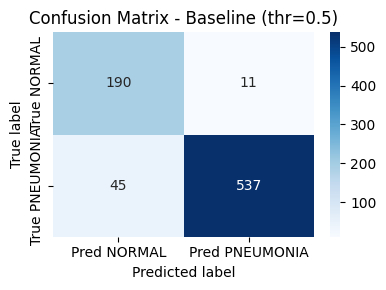

In [ ]:
# ============== 9) EVALUASI BASELINE (thr=0.5) ==============
import seaborn as sns
import matplotlib.pyplot as plt

val_probs = model.predict(val_gen, verbose=1).ravel()
val_true  = val_gen.classes
test_probs = model.predict(test_gen, verbose=1).ravel()
test_true  = test_gen.classes

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def metrics_at_threshold(y_true, probs, thr=0.5):
    y_pred = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)      # sensitivity Pneumonia
    specificity = tn/(tn+fp+1e-9)                                  # specificity Normal
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    cm = np.array([[tn, fp], [fn, tp]])
    return dict(precision=precision, recall=recall, specificity=specificity,
                f1=f1, accuracy=acc, cm=cm)

# Hitung metrik di threshold 0.5
m05 = metrics_at_threshold(test_true, test_probs, thr=0.5)

print("== TEST metrics @ thr=0.5 ==")
for k, v in m05.items():
    if k != "cm":
        print(f"{k}: {v:.4f}")
print("Confusion Matrix:\n", m05["cm"])

print("\nAUC (TEST):", roc_auc_score(test_true, test_probs))
print("\nClassification report @ thr=0.5:")
print(classification_report(test_true, (test_probs >= 0.5).astype(int), target_names=list(label_to_index.keys())))

# ===== Visualisasi Confusion Matrix =====
plt.figure(figsize=(4, 3))
sns.heatmap(
    m05["cm"],
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred NORMAL", "Pred PNEUMONIA"],
    yticklabels=["True NORMAL", "True PNEUMONIA"],
)
plt.title("Confusion Matrix - Baseline (thr=0.5)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


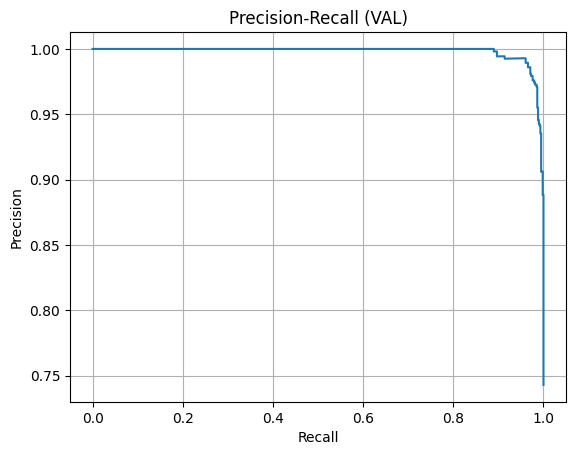

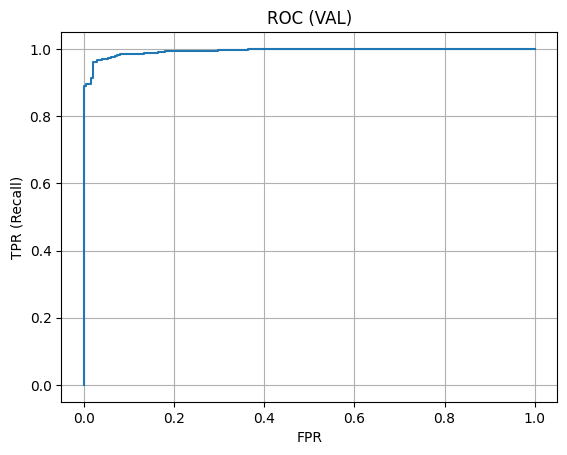

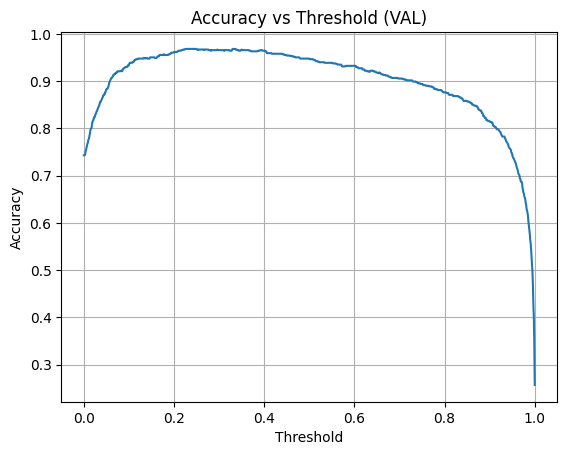

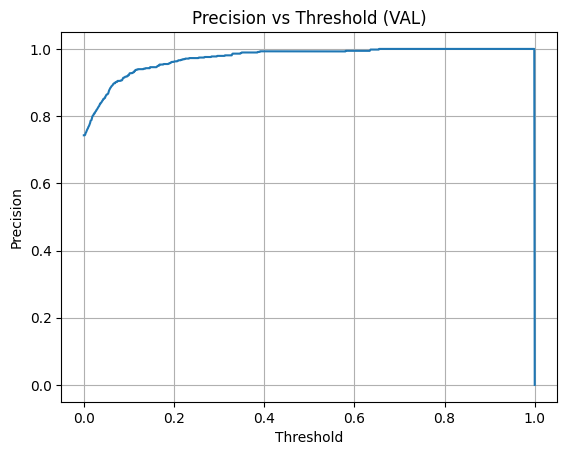

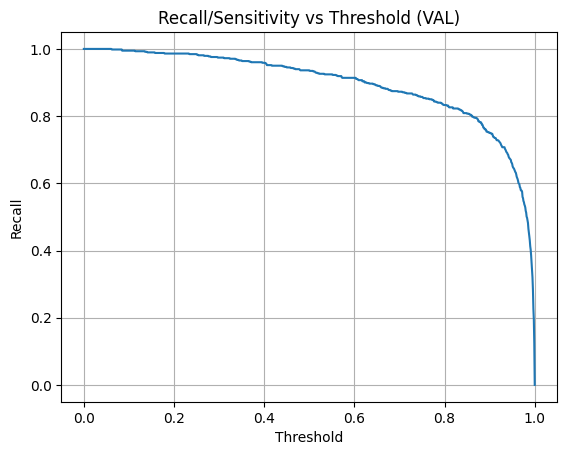

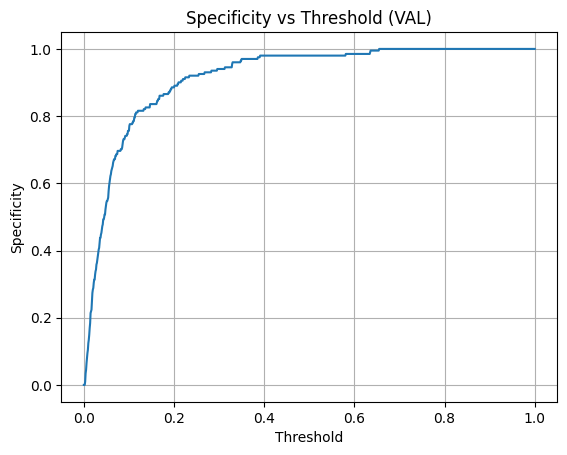

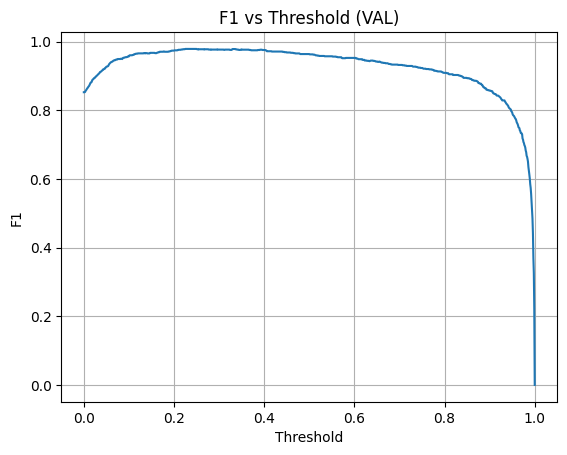

In [ ]:
# ============== 10) KURVA & DIAGRAM METRIK vs THRESHOLD (VAL) ==============
prec, rec, pr_thr = precision_recall_curve(val_true, val_probs)
fpr, tpr, roc_thr = roc_curve(val_true, val_probs)

plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall (VAL)"); plt.grid(True); plt.show()
plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR (Recall)"); plt.title("ROC (VAL)"); plt.grid(True); plt.show()

ts = np.linspace(0,1,1001)
accs, precs, recalls, specs, f1s = [], [], [], [], []
for t in ts:
    yhat = (val_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(val_true, yhat).ravel()
    accs.append((tp+tn)/(tp+tn+fp+fn+1e-9))
    precs.append(precision_score(val_true, yhat, zero_division=0))
    recalls.append(recall_score(val_true, yhat, zero_division=0))
    specs.append(tn/(tn+fp+1e-9))
    f1s.append(f1_score(val_true, yhat, zero_division=0))

def plot_metric(ts, values, title, ylabel):
    plt.figure(); plt.plot(ts, values); plt.title(title); plt.xlabel("Threshold"); plt.ylabel(ylabel); plt.grid(True); plt.show()

plot_metric(ts, accs,   "Accuracy vs Threshold (VAL)", "Accuracy")
plot_metric(ts, precs,  "Precision vs Threshold (VAL)", "Precision")
plot_metric(ts, recalls,"Recall/Sensitivity vs Threshold (VAL)", "Recall")
plot_metric(ts, specs,  "Specificity vs Threshold (VAL)", "Specificity")
plot_metric(ts, f1s,    "F1 vs Threshold (VAL)", "F1")

thr_recall95 (sens PNEUMONIA≥0.95): 0.391
thr_spec95  (spec NORMAL≥0.95)    : 0.330
thr_youden  (maks Youden)         : 0.391
thr_f1      (maks F1)             : 0.225

== TEST @ Recall≥95% (PNEUMONIA) (thr=0.391) ==
precision: 0.9769
recall: 0.9450
specificity: 0.9353
f1: 0.9607
accuracy: 0.9425
CM:
 [[188  13]
 [ 32 550]]


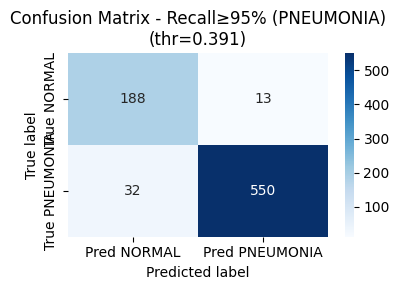


== TEST @ Specificity≥95% (NORMAL) (thr=0.330) ==
precision: 0.9724
recall: 0.9674
specificity: 0.9204
f1: 0.9699
accuracy: 0.9553
CM:
 [[185  16]
 [ 19 563]]


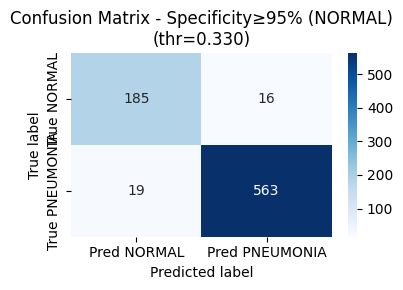


== TEST @ Youden (thr=0.391) ==
precision: 0.9769
recall: 0.9450
specificity: 0.9353
f1: 0.9607
accuracy: 0.9425
CM:
 [[188  13]
 [ 32 550]]


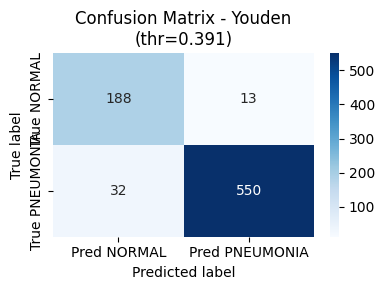


== TEST @ F1-opt (thr=0.225) ==
precision: 0.9630
recall: 0.9828
specificity: 0.8905
f1: 0.9728
accuracy: 0.9591
CM:
 [[179  22]
 [ 10 572]]


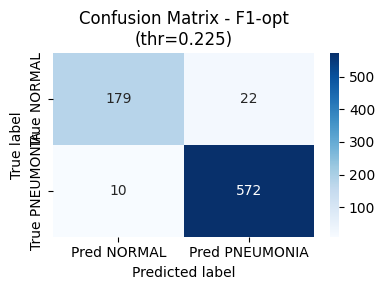

In [ ]:
# ============== 11) PILIH THRESHOLD: PRO-NORMAL & PRO-PNEUMONIA + YOUDEN & F1-OPT + PLOT CM ==============
import seaborn as sns
import matplotlib.pyplot as plt

ts = np.linspace(0, 1, 1001)
vals = []
for t in ts:
    yhat = (val_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(val_true, yhat).ravel()
    sens = tp / (tp + fn + 1e-9)        # recall pneumonia
    spec = tn / (tn + fp + 1e-9)        # specificity normal
    f1 = f1_score(val_true, yhat, zero_division=0)
    youd = sens + spec - 1
    vals.append((t, sens, spec, f1, youd))

# --- Cari threshold ---
thr_recall95, thr_spec95, thr_youden, thr_f1 = 0.5, 0.5, 0.5, 0.5

cands = [(t, sens, spec) for (t, sens, spec, _, _) in vals if sens >= 0.95]
if cands:
    cands.sort(key=lambda x: (-x[2], -x[1]))
    thr_recall95 = float(cands[0][0])

cands = [(t, sens, spec) for (t, sens, spec, _, _) in vals if spec >= 0.95]
if cands:
    cands.sort(key=lambda x: (-x[1], -x[2]))
    thr_spec95 = float(cands[0][0])

thr_youden = float(sorted(vals, key=lambda x: x[4], reverse=True)[0][0])
thr_f1 = float(sorted(vals, key=lambda x: x[3], reverse=True)[0][0])

print(f"thr_recall95 (sens PNEUMONIA≥0.95): {thr_recall95:.3f}")
print(f"thr_spec95  (spec NORMAL≥0.95)    : {thr_spec95:.3f}")
print(f"thr_youden  (maks Youden)         : {thr_youden:.3f}")
print(f"thr_f1      (maks F1)             : {thr_f1:.3f}")

# --- Fungsi metrik + visualisasi CM ---
def metrics_at_threshold(y_true, probs, thr=0.5):
    y_pred = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp + 1e-9)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    cm = np.array([[tn, fp], [fn, tp]])
    return dict(precision=precision, recall=recall, specificity=specificity,
                f1=f1, accuracy=acc, cm=cm)

def show_metrics(name, thr):
    m = metrics_at_threshold(test_true, test_probs, thr=thr)
    print(f"\n== TEST @ {name} (thr={thr:.3f}) ==")
    for k, v in m.items():
        if k != "cm":
            print(f"{k}: {v:.4f}")
    print("CM:\n", m["cm"])

    # --- Plot confusion matrix heatmap ---
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        m["cm"],
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Pred NORMAL", "Pred PNEUMONIA"],
        yticklabels=["True NORMAL", "True PNEUMONIA"],
    )
    plt.title(f"Confusion Matrix - {name}\n(thr={thr:.3f})")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

# --- Jalankan evaluasi + tampilkan CM ---
show_metrics("Recall≥95% (PNEUMONIA)", thr_recall95)
show_metrics("Specificity≥95% (NORMAL)", thr_spec95)
show_metrics("Youden", thr_youden)
show_metrics("F1-opt", thr_f1)


In [ ]:
# ============== PREDIKSI GAMBAR (simple display) ==============
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

def predict_simple(img_path, target_size=(224,224), thr=0.5):
    """Prediksi 1 gambar dan kembalikan (label_pred, prob_pneumonia, confidence)."""
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    prob = float(model.predict(x, verbose=0)[0,0])
    label = "PNEUMONIA" if prob >= thr else "NORMAL"
    confidence = prob if label == "PNEUMONIA" else (1.0 - prob)
    return img, label, confidence, prob

# ---- path gambar uji coba ----
IMG_SELF = "/NORMAL2.jpg"   # ganti dengan file yang akan diupload

if not os.path.exists(IMG_SELF):
    print(f"File {IMG_SELF} tidak ditemukan. Upload gambar dulu ke notebook.")
else:
    img, label, conf, prob_pneumonia = predict_simple(IMG_SELF, target_size=IMG_SIZE, thr=0.5)

    # tampilkan hanya label + confidence
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {label}  |  Confidence: {conf*100:.1f}%")
    plt.show()

    # (opsional) satu baris ringkas di console
    print(f"Prediction: {label} | prob(PNEUMONIA)={prob_pneumonia:.3f} | confidence={conf*100:.1f}%")


File /NORMAL2.jpg tidak ditemukan. Upload gambar dulu ke notebook.
